# Learning rate schedule

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules

In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    return score


def dice_coef(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [3]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
                #image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')

            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

In [4]:
len(train_generator)

46

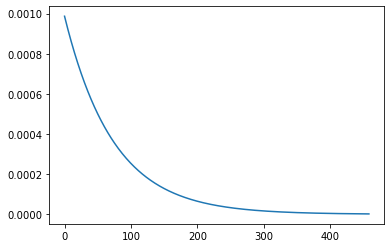

In [9]:
def decayed_learning_rate(step):
    initial_learning_rate = 0.001
    decay_rate = 0.96
    decay_steps = 3
    return initial_learning_rate * decay_rate ** (step / decay_steps)

lrs = [decayed_learning_rate(i) for i in range(1, 46*10)]
plt.plot(lrs)

In [11]:
from tensorflow.keras import optimizers

lr_schedule = optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=3,
    decay_rate=0.96
)
optimizer = optimizers.Adam(lr_schedule)

In [12]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet
from tensorflow.keras import optimizers

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    use_attention=True,
    output_activation='sigmoid')

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[iou])
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (Spati

In [9]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
46/46 [==============================] - 62s 1s/step - loss: 0.9718 - iou: 0.4023 - val_loss: 10.5782 - val_iou: 0.3067
Epoch 2/10
46/46 [==============================] - 55s 1s/step - loss: 0.6864 - iou: 0.5259 - val_loss: 6.6720 - val_iou: 0.3490
Epoch 3/10
46/46 [==============================] - 54s 1s/step - loss: 0.5842 - iou: 0.5833 - val_loss: 2.4568 - val_iou: 0.4413
Epoch 4/10
46/46 [==============================] - 55s 1s/step - loss: 0.5159 - iou: 0.6234 - val_loss: 1.5880 - val_iou: 0.5893
Epoch 5/10
46/46 [==============================] - 55s 1s/step - loss: 0.4804 - iou: 0.6450 - val_loss: 0.7743 - val_iou: 0.6708
Epoch 6/10
46/46 [==============================] - 55s 1s/step - loss: 0.4416 - iou: 0.6699 - val_loss: 0.5588 - val_iou: 0.6858
Epoch 7/10
46/46 [==============================] - 54s 1s/step - loss: 0.4218 - iou: 0.6833 - val_loss: 0.4843 - val_iou: 0.7069
Epoch 8/10
46/46 [==============================] - 55s 1s/step - loss: 0.4067 - iou: 0.6

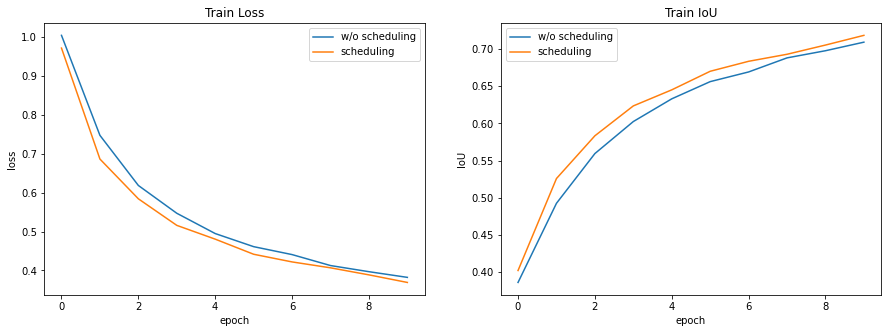

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses[:10], label='w/o scheduling')
plt.plot(history.history['loss'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Train Loss")

plt.subplot(1, 2, 2)
plt.plot(train_ious[:10], label='w/o scheduling')
plt.plot(history.history['iou'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title("Train IoU")
plt.show()

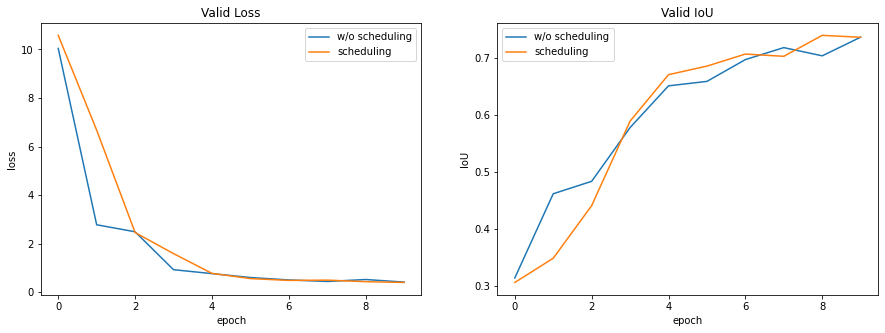

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(valid_losses[:10], label='w/o scheduling')
plt.plot(history.history['val_loss'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Valid Loss")

plt.subplot(1, 2, 2)
plt.plot(valid_ious[:10], label='w/o scheduling')
plt.plot(history.history['val_iou'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title("Valid IoU")
plt.show()